![Codenation](https://forum.codenation.com.br/uploads/default/original/2X/2/2d2d2a9469f0171e7df2c4ee97f70c555e431e76.png)

__Autor__: Kazuki Yokoyama (kazuki.yokoyama@ufrgs.br)

# Redução de dimensionalidade e seleção de variáveis

![cover](https://science.sciencemag.org/content/sci/290/5500/2323/F1.large.jpg?width=800&height=600&carousel=1)

Neste módulo abordaremos dois assuntos bastante relacionados e frequentemente confundidos.

Redução de dimensionalidade é a tarefa de reduzir a dimensão de um _data set_ através de transformações das variáveis originais. Seleção de variáveis (ou, em Inglês, _feature selection_) é a tarefa de reduzir o número de variáveis originais, removendo aquelas que acrescentam pouco ou nenhum valor para a tarefa de predição.

A diferença pode ser sutil: enquanto na redução de dimensionalidade trazemos os dados para um espaço de menor dimensionalidade criando __novas variáveis__, na seleção de variáveis simplesmente filtramos as variáveis pouco relevantes fora e mantemos apenas um subconjunto das __variáveis originais__ relevantes.

## Importação das bibliotecas

In [0]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA

In [0]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [0]:
np.random.seed(42)

## Redução de dimensionalidade

Antes de falarmos de redução de dimensionalidade, precisamos esclarecer __por que__ queremos diminuir a dimensionalidade.

A dimensionalidade de um _data set_ é o número de variáveis neste _data set_, geralmente ignorando a variáveis alvo. Por exemplo, o _data set_ [Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) possui quatro variáveis explicativas (suas quatro dimensões) e uma variável alvo (a espécie da planta). Porém, outros _data sets_ possuem até dezenas de milhares de variáveis. Um exemplo bom disso são os _data sets_ de imagens, onde cada pixel é representado por uma variável (e seu valor é sua cor em RGB ou escala de cinza, por exemplo). A partir de algumas dezenas de variáveis, normalmente passamos a considerar o _data set_ como de alta dimensionalidade.

É de se imaginar que muitas das informações contidas nas variáveis de _data sets_ de altas dimensões são redundantes. Por exemplo, ao considerar fotos, é fácil perceber que os pixels das bordas das fotos pouco variam (normalmente sendo brancos) e que pixels adjacentes variam muito pouco entre si. Nos perguntamos se não podemos "compactar" essa informação em um número menor de variáveis.

Além de remover redundância, podemos estar interessados em diminuir a dimensionalidade para tornar certos problemas tratáveis. Alguns algoritmos não lidam bem com dados em altas dimensões, e isso tem a ver com a maldição da dimensionalidade (do Inglês, _curse of dimensionality_).

### Maldição da dimensionalidade

O primeiro problema óbvio com as altas dimensões é que nós só conseguimos enxergar até três dimensões. Se precisamos visualizar um _data set_ cuja dimensão é superior a três, então plotamos as variáveis dois a dois (ou três a três) e acabamos perdendo informação nesse processo, pois não conseguimos visualizar todas variáveis ao mesmo tempo.

O outro problema tem a ver com as distâncias nos espaços de altas dimensões (ou hiperespaços). Em altas dimensões, os pontos, mesmo quando uniformemente distribuídos, são naturalmente muito afastados uns dos outros. Dizemos que hiperespaços são esparsos ou pouco densos.

Por exemplo, a probabilidade de se tomar um ponto aleatório a uma distância inferior a 0.001 da borda de um quadrado de lado unitário é 0.4%. Porém a probabilidade se tomar um ponto aleatório a uma distância inferior a 0.001 da borda de um hipercubo unitário de 10000 dimensões é maior que 99.999999%. Em outras palavras, nesse último cenário, os dados encontram-se muito concentrados nas bordas e pouco densos nos centros. O resultado é que __em altas dimensões os dados encontram-se muito afastados uns dos outros__.

Qualquer algoritmo que considere a distância (geralmente Euclideana) entre pontos é penalizado pela noção distorcida de distância nesses espaços de altas dimensões, prejudicando a performance. Nos hiperespaços é muito provável que qualquer novo dado de teste encontre-se muito afastado dos dados de treinamento do modelo, tornando a sua predição pouco confiável.

Uma solução seria aumenta o número de dados, a fim de tornar nosso conjunto mais denso. Existem dois problemas com essa solução. Primeiramente, em muitos casos práticos é muito difícil conseguir novos dados. Além disso, essa solução não escalaria adequadamente. A proporção de que precisamos de novos dados para compensar o número de dimensões tem crescimento exponencial.

Por fim, nos resta diminuir a dimensionalidade, mas mantendo o máximo de informação relevante possível.

Antes de prosseguirmos, devemos falar um pouco mais sobre dimensões e sobre o _kernel trick_.

### _Kernel trick_

O _kernel trick_ é uma técnica matemática que torna a implementação de vários algoritmos de ML muito mais eficientes. A ideia é a seguinte:

Considere que você possui dados $\mathbf{x}$ pertencentes a um espaço de entrada $\mathcal{I}$. Em vez de trabalhar com $\mathbf{x}$, pode ser mais interessante trabalhar com alguma representação de $\mathbf{x}$ em um outro espaço, $\mathcal{F}$, chamado espaço de _features_ (talvez mais rico para o problema em mãos). O que precisamos é de uma função, $\phi$, que mapeie dados de $\mathcal{I}$ em $\mathcal{F}$, ou seja:

$$\phi(\mathbf{x}): \mathcal{I} \rightarrow \mathcal{F}$$

O resultado da função, $\phi(\mathbf{x})$, pode conter relações não lineares entre as variáveis do nosso conjunto, de forma que conseguimos capturar e aproveitar tais relações nos nossos modelos. Se continuássemos operando no espaço original $\mathcal{I}$, talvez não descobriríamos essas relações interessantes.

Por exemplo, considere os dados $\mathbf{x} = [x_{1}, x_{2}]^{T}$ e a função $\phi(\mathbf{x}) = [x_{1}^{2}, x_{2}^{2}, x_{1} x_{2} \sqrt{2}]^{T}$ que mapeia de $\mathcal{I} = \mathcal{R}^{2}$ em $\mathcal{F} = \mathcal{R}^{3}$. Um dado ponto $\mathbf{x} = [1, 2]^{T} \in \mathcal{I}$ seria mapeado para $\phi(\mathbf{x}) = [1^{2}, 2^{2}, 1 \times 2 \times \sqrt{2}]^{T} = [1, 4, 2\sqrt{2}]^{T} \in \mathcal{F}$.

O problema é que computar $\phi$ para todos os pontos $x_{i}$ do nosso _data set_ $\mathbf{D}$ pode ser bem custoso e às vezes impossível (no caso de $\mathcal{F}$ ser infinito, o que pode acontecer). Além disso, $\mathcal{F}$ pode ter alta dimensão, o que nos faria cair no problema da _curse of dimensionality_ falado acima.

A solução é não calcular $\phi$ explicitamente, mas sim utilizar os resultados finais de operações úteis de $\phi$ em $\mathcal{F}$. Considere nosso _data set_ $\mathbf{D} = \{\mathbf{x}_{1}, \mathbf{x}_{2}, \cdots, \mathbf{x}_{i}, \cdots, \mathbf{x}_{n}\}$ com $n$ dados. Definimos a matriz _kernel_ de similaridade da seguinte forma:

$$
\mathbf{K} = 
\begin{pmatrix}
  K(\mathbf{x}_{1}, \mathbf{x}_{1}) & K(\mathbf{x}_{1}, \mathbf{x}_{2}) & \cdots & K(\mathbf{x}_{1}, \mathbf{x}_{n}) \\
  K(\mathbf{x}_{2}, \mathbf{x}_{1}) & K(\mathbf{x}_{2}, \mathbf{x}_{2}) & \cdots & K(\mathbf{x}_{2}, \mathbf{x}_{n}) \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  K(\mathbf{x}_{n}, \mathbf{x}_{1}) & K(\mathbf{x}_{n}, \mathbf{x}_{2}) & \cdots & K(\mathbf{x}_{n}, \mathbf{x}_{n}) 
 \end{pmatrix}
$$

onde $K: \mathcal{I} \times \mathcal{I} \rightarrow \mathcal{F}$ é chamada função _kernel_ e mapeia dois elementos do espaço de entrada em um elemento do espaço de _features_. Essa função deve, além de alguns outros critérios, representar um produto interno no espaço de _features_. Em outras palavras:

$$K(\mathbf{x}_{i}, \mathbf{x}_{j}) = \phi(\mathbf{x}_{i})^{T} \phi(\mathbf{x}_{j})= <\phi(\mathbf{x}), \phi(\mathbf{y})> = \phi(\mathbf{x}) \cdot \phi(\mathbf{y})$$

A grande ideia é que, em vez de computarmos todos $\phi$, computamos somente $\mathbf{K}$, o que facilita o nosso trabalho.

No exemplo anterior, o produto interno $\phi(\mathbf{x})^{T} \phi(\mathbf{y}) = x_{1}^{2} y_{1}^{2} + x_{2}^{2} y_{2}^{2} + 2 x_{1} x_{2} y_{1} y_{2} = (\mathbf{x}^{T} \mathbf{y})^{2} = K(\mathbf{x}, \mathbf{y})$. De fato,

$$\phi([1, 2])^{T} \phi([3, 4]) = [1^{2}, 2^{2}, 1 \times 2 \times \sqrt{2}]^{T} \cdot [3^{2}, 4^{2}, 3 \times 4 \times \sqrt{2}]^{T} = 121$$

Ou calculando a função _kernel_:

$$K([1, 2], [3, 4]) = ([1, 2]^{T} [3, 4])^{2} = 11^{2} = 121$$

Do conhecimento de $\mathbf{K}$ e sendo possível, podemos escrever nossos algoritmos de ML em função de produtos internos das _features_ e calcular tudo utilizando a matriz $\mathbf{K}$, sem necessidade de calcular as _features_ $\phi$ explicitamente. Por sorte, vários algoritmos permitem isso e são chamados _kernelizáveis_. Como grandes exemplos temos o SVM e o PCA, que veremos a seguir.

Note que, no exemplo anterior

$$K(\mathbf{x}, \mathbf{y}) = (\mathbf{x}^{T} \mathbf{y})^{2} = \phi(\mathbf{x})^{T} \phi(\mathbf{y})$$

Por esse motivo, essa função _kernel_ é chamada quadrática.



Se não elevássemos ao quadrado, teríamos

$$K(\mathbf{x}, \mathbf{y}) = (\mathbf{x}^{T} \mathbf{y}) = \phi(\mathbf{x})^{T} \phi(\mathbf{y})$$

da onde

$$\phi(\mathbf{x}) = \mathbf{x}$$ e

$$\phi(\mathbf{y}) = \mathbf{y}$$

Nesse caso, $K$ é chamada de função _kernel_ linear.

Outra função _kernel_ muito útil e famosa é a RBF (_Radial Basis Function_) ou função _kernel_ Gaussiana:

$$K(\mathbf{x}, \mathbf{y}) = e^{-\|\mathbf{x} - \mathbf{y}\|^{2}/2\sigma^{2}}$$

onde $\sigma > 0$.

O interessante sobre a RBF é que ela mapeia para um espaço $\mathcal{F}$ infinito. Visto de outra forma, é impossível calcular $\phi(\mathbf{x})$ explicitamente. Ainda assim, com a ajuda do _kernel trick_, podemos calcular produtos internos de $\phi$, ou seja $K$, de forma muito simples.

![kernel-trick](https://cdn-images-1.medium.com/max/1600/0*ngkO1BblQXnOTcmr.png)

Por fim, vale notar que é possível escrever diversas operações, como norma de um ponto, distância entre pontos, média de pontos etc, do espaço de _features_ $\mathcal{F}$ em função da função de _kernel_ $K$, sem ter que calcular as transformações $\phi$.

## PCA

![pca](https://miro.medium.com/max/796/1*H38t3YUv_QktLwalzDYRRg.png)

PCA (_Principal Component Analysis_) é uma técnica estatística para redução de dimensionalidade. A ideia é criar variáveis (componentes) que capturem o máximo de variância (i.e., _informação_) dos dados originais. Com esses componentes podemos criar visualizações 2D ou 3D, procurar por agrupamentos e alimentar algoritmos.

Se tivermos um _data set_ original com $p$ dimensões, ou seja, $p$ variáveis, podemos procurar por $d$ componentes principais (com $d < p$). Denotemos as variáveis por $X_{1}, X_{2}, \dots, X_{p}$, então podemos escrever o primeiro componente principal através da combinação linear:

$$Z_{1} = \phi_{11}X_{1} + \phi_{21}X_{2} + \cdots + \phi_{p1}X_{p} = \sum_{1 \leq j \leq p} \phi_{j1}X_{j}$$

$$Z_{1} = 1.2 \begin{bmatrix}1 \\ 2 \end{bmatrix} + 3.4 \begin{bmatrix}0 \\ 3 \end{bmatrix} = \begin{bmatrix}1.2 \\ 12.6 \end{bmatrix}$$

Os valores $\phi_{ij}$ são chamados de _loadings_ da PCA, e juntos formam o vetor de _loadings_ $\vec{\phi}_{1} = [\phi_{11}, \phi_{21}, \cdots, \phi_{p1}]^{T}$

> O segundo índice do subscrito indica de qual componente estamos falando. Neste caso, 1 indica que é do primeiro componente.

Note que $Z_{1}$ é um vetor, i.e., $Z_{1} = [z_{11}, z_{21}, \cdots, z_{p1}]^{T}$, onde

$$z_{i1} = \phi_{11}x_{i1} + \phi_{21}x_{i2} + \cdots + \phi_{p1} x_{ip} = \sum_{1 \leq j \leq p} \phi_{j1} x_{ij}$$

A questão é: como determinamos $\vec{\phi}_{1}$?

Vamos assumir que $X_{1}, X_{2}, \cdots$ foram centralizados para ter média zero, mas mantidas suas variâncias. Então podemos tentar maximizar a variância de $Z_{1}$ com a restrição de que os _loadings_ são limitados a um circulo unitário. Em outras palavras:

$$\underset{\phi_{11}, \phi_{21}, \cdots, \phi_{p1}}{\text{maximizar }} \left\{\text{Var}[Z_{1}] = \mathbb{E}[Z_{1}^{2}] - \underbrace{\mathbb{E}[Z_{1}]^{2}}_{0} = \frac{1}{n} \sum_{1 \leq i \leq n} z_{i1}^{2} = \frac{1}{n} \sum_{1 \leq i \leq n} \left( \sum_{1 \leq j \leq p} \phi_{j1} x_{ij}\right)^{2} \right\}\text{ restrito a } \sum_{1 \leq j \leq p} \phi_{j1}^{2} = 1$$

> Se ajudar a não se perder: $i$ denota a linha do _data set_ (que vai de 1 a $n$), enquanto $j$ denota a coluna ou variável (que vai de 1 a $p$).

O segundo componente principal, $Z_{2}$, segue exatamente o mesmo raciocínio do primeiro componente, exceto que ele deve ser não correlacionado com $Z_{1}$, o que significa que $\vec{\phi}_{2}$ deve ser ortogonal a $\vec{\phi}_{1}$.

Todos os demais componentes principais, que podem ser no máximo $p$, seguem esse raciocínio, sempre não correlacionados (ortogonais) a todos componentes principais anteriores.

Ao fim desse processo, teremos vários componentes principais, sendo que o primeiro captura a maior fração da variância total dos dados, o segundo captura a segunda maior fração da variância total e assim por diante. A soma das frações da variância capturadas por todos $p$ componentes principais deve ser portanto igual a 1.

![minmax](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

O PCA também pode ser encarado do ponto de vista geométrico. Uma componente do PCA tenta sempre achar a direção, ortogonal a todos os componentes anteriores, que maximiza a variância dos dados e minimiza a distância residual (quadrado da distância Euclideana) dos pontos.

Esse problema de maximização pode ser resolvido com SVD (_Singular Value Decomposition_) que é uma fatoração de matriz padrão em álgebra linear. Se $\mathbf{X}$ for o nosso _data set_, o algoritmo do SVD nos fornece:

$$\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^{T}$$

onde $\mathbf{V} = [\vec{\phi}_{1}, \vec{\phi}_{2}, \cdots, \vec{\phi}_{p}]$.

Mas quantos componentes principais precisamos?

Isso depende do problema em mãos.

Se o nosso intuito for visualização, podemos pegar só os dois ou três primeiros componentes principais. Se, por outro lado, estivermos interessados em algo diferente, como alimentar um algoritmo ou buscar um padrão de _cluster_, podemos pegar tantos componentes principais quantos forem necessários para explicar uma boa parte da variância total. Por boa parte, geralmente falamos de 95% da variância total ou algo perto disso.

Uma boa técnica é analisar o "cotovelo" (_elbow_) da curva de variância explicada do PCA.

In [0]:
digits = load_digits()

digits.data.shape

(1797, 64)

In [0]:
pca = PCA(n_components=2)

projected = pca.fit_transform(digits.data)

print(f"Original shape: {digits.data.shape}, projected shape: {projected.shape}")

Original shape: (1797, 64), projected shape: (1797, 2)


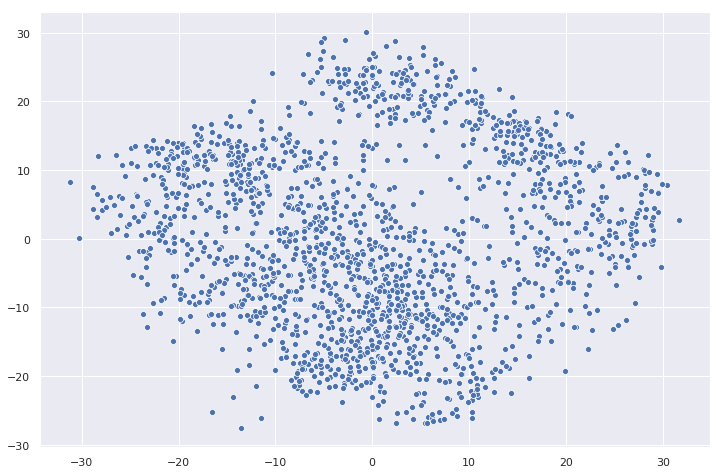

In [0]:
sns.scatterplot(projected[:, 0], projected[:, 1]);

In [0]:
pca = PCA().fit(digits.data)

evr = pca.explained_variance_ratio_

evr

array([1.48905936e-01, 1.36187712e-01, 1.17945938e-01, 8.40997942e-02,
       5.78241466e-02, 4.91691032e-02, 4.31598701e-02, 3.66137258e-02,
       3.35324810e-02, 3.07880621e-02, 2.37234084e-02, 2.27269657e-02,
       1.82186331e-02, 1.77385494e-02, 1.46710109e-02, 1.40971560e-02,
       1.31858920e-02, 1.24813782e-02, 1.01771796e-02, 9.05617439e-03,
       8.89538461e-03, 7.97123157e-03, 7.67493255e-03, 7.22903569e-03,
       6.95888851e-03, 5.96081458e-03, 5.75614688e-03, 5.15157582e-03,
       4.89539777e-03, 4.28887968e-03, 3.73606048e-03, 3.53274223e-03,
       3.36683986e-03, 3.28029851e-03, 3.08320884e-03, 2.93778629e-03,
       2.56588609e-03, 2.27742397e-03, 2.22277922e-03, 2.11430393e-03,
       1.89909062e-03, 1.58652907e-03, 1.51159934e-03, 1.40578764e-03,
       1.16622290e-03, 1.07492521e-03, 9.64053065e-04, 7.74630271e-04,
       5.57211553e-04, 4.04330693e-04, 2.09916327e-04, 8.24797098e-05,
       5.25149980e-05, 5.05243719e-05, 3.29961363e-05, 1.24365445e-05,
      

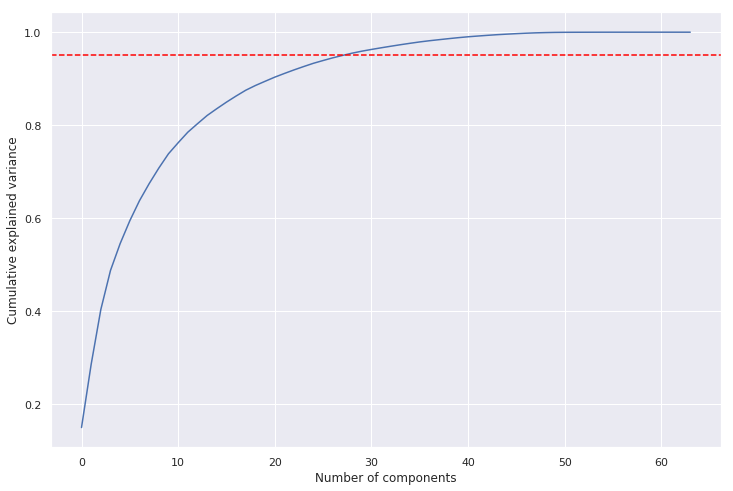

In [0]:
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

Podemos achar o número de componentes necessários para explicar determinada fração da variância total:

In [0]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
component_number = np.argmax(cumulative_variance_ratio >= 0.95) + 1 # Contagem começa em zero.

component_number

29

Mas o PCA do sklearn também nos permite achar diretamente as componentes principais justamente necessárias para essa fração da variância total. Para isso, basta especificar a fração da variância total que se quer acumular no parâmetro `n_components` em vez do número de componentes:

In [0]:
pca_095 = PCA(n_components=0.95)
X_reduced = pca_095.fit_transform(digits.data)

X_reduced.shape # Segundo elemento da tupla é o número de componentes encontrados.

(1797, 29)

![swiss-roll](https://openi.nlm.nih.gov/imgs/512/393/4801566/PMC4801566_sensors-16-00189-g002.png?keywords=add)

## Seleção de variáveis

O segundo tópico deste módulo é seleção de variáveis: como podemos diminuir o número de variáveis do nosso _data set_, mantendo somente aquelas que são relevantes para o problema?

Veremos três abordagens para esse problema: busca completa, _forward stepwise selection_ e _backward stepwise selection_.


### Busca completa

O primeiro é a busca completa por força bruta. Se o nosso conjunto possui $p$ variáveis, podemos verificar todas $2^{p}$ combinações de variáveis para descobrir qual combinação, ou seja, qual subconjunto de variáveis nos leva ao melhor modelo (algoritmo retirado de Tibshirani et al.):

```
1 Seja M0 o modelo nulo, ou seja, o modelo sem nenhum variável preditiva.
2. Para k = 1, 2, ..., p:
    2.1. Construa todos C(p, k) modelos que contém exatamente k variáveis.
    2.2. Escolha o melhor modelo dentre os C(p, k) modelos construídos e o chame de Mk.
3. Escolha o melhor modelo entre M0, M1, ..., Mp usando cross-validation, Cp, AIC ou R-quadrado ajustado.
```

Esse método é bem força bruta. Ele tenta buscar dentre todos $2^{p}$ o melhor subconjunto de variáveis.

Quando comparando modelos com mesmo número de variáveis como no passo 2, é justo utilizar uma medida como $R^{2}$. Porém, quando comparando modelos com números diferentes de variáveis, como no passo 3, o $R^{2}$ (e algumas outras métricas) não são mais justas, já que podem dar melhor resultado quanto mais variáveis no modelo. Por esse motivo, devemos utilizar critérios de decisão que sejam robustos ao número de variáveis como $R^{2}$ ajustado ou $C_{p}$, AIC etc.

### _Forward stepwise selection_

Devido ao grande espaço de buscas do método da busca completa, pode ser inviável utilizá-lo na prática. Os métodos _stepwise_ utilizam uma busca guiada, adicionando ou removendo uma variável por vez e selecionando o subconjunto que leva ao melhor modelo achado.

O _forward stepwise selection_ (FSS) começa com um modelo vazio (sem variáveis) e vai adicionando uma variável por vez, aquela que for considerada a melhor no momento, até que todas variáveis tenham sido adicionadas ao modelo. Por fim, escolhe o subconjunto de variáveis cujo modelo teve o melhor desempenho. O algoritmo do FSS é delineado abaixo:

```
1 Seja M0 o modelo nulo, ou seja, o modelo sem nenhum variável preditiva.
2. Para k = 0, 1, ..., p-1:
    2.1. Considere todos p-k modelos que aumentem o subconjunto de variáveis em Mk com uma variável a mais.
    2.2. Escolha o melhor modelo dentre os p-k modelos construídos e o chame de Mk+1.
3. Escolha o melhor modelo entre M0, M1, ..., Mp usando cross-validation, Cp, AIC ou R-quadrado ajustado.
```

Esse algoritmo é bem similar ao anterior, mas agora consideramos um número bem menor de modelos. Apesar de ser bem mais rápido e escalável que a busca completa, o FSS pode não encontrar o melhor subconjunto global de variáveis.

### _Backward stepwise selection_

O _backward stepwise selection_ (BSS) é muito parecido com o FSS, mas desta vez começamos com o modelo completo (com todas $p$ variáveis) e vamos removendo uma a uma, aquela que menos contribuir para o modelo, até que cheguemos ao modelo nulo (sem variáveis). Depois, selecionamos o modelo achado que teve o melhor desempenho. O algoritmo é mostrado abaixo:

```
1 Seja Mp o modelo completo, ou seja, o modelo com todas variáveis preditivas.
2. Para k = p, p-1, ..., 1:
    2.1. Considere todos k modelos que contém todas variáveis de Mk, exceto uma, com um total de k-1 variáveis.
    2.2. Escolha o melhor modelo dentre os p-k modelos construídos e o chame de Mk-1.
3. Escolha o melhor modelo entre M0, M1, ..., Mp usando cross-validation, Cp, AIC ou R-quadrado ajustado.
```

O BSS é conceitualmente bem parecido com o FSS, mas possui uma implicação importante. Como ele começa com o modelo completo, pode ser infactível utilizá-lo em determinados cenários onde o número de variáveis já é superior ao número de observações. Neste caso, o FSS continua válido e é uma melhor opção.

## Referências

* [StackExchange - Relationship between SVD and PCA. How to use SVD to perform PCA?](https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca)

* [Singular Value Decomposition andPrincipal Component Analysis](http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/4000/pdf/imm4000)

* [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

* [In-Depth: Manifold Learning](https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html)

* [Recursive Feature Elimination](https://bookdown.org/max/FES/recursive-feature-elimination.html)

* [A Tutorial on Principal Component Analysis](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf)

* [Principal Component Analysis Explained](https://www.kaggle.com/nirajvermafcb/principal-component-analysis-explained)

* [Step Forward Feature Selection: A Practical Example in Python](https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html)